### Import packages

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import signal
import glob
import antropy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import butter, sosfilt, sosfreqz, detrend,stft
import math
from scipy.signal import stft,find_peaks
from scipy.stats import kurtosis,skew
import seaborn as sns

### Extract Raw sensor readings from raw files

In [2]:
sensor_list = ['IMU_1_x','IMU_1_y','IMU_1_z','Prox','IMU_2_x','IMU_2_y','IMU_2_z']

In [3]:
### Convert labels to 1 (chewing) or 0 (non-chewing)
def chewing_label(row):
    if '1' in str(row['label']) or row['label'] == 0 or row['label'] == 2:
        return 1
    else:
        return 0
###  Create dataframes from raw readings and assign eating and chewing labels   
def raw_process(raw,labelled):
    raw_transposed = raw.T
    labelled = labelled.dropna(how = 'all')
    data_pt = labelled.iloc[:,0]
    raw_transposed = raw_transposed.rename(columns = {0:'IMU_1_x',1:'IMU_1_y',2:'IMU_1_z',3:'Prox',4:'IMU_2_x',5:'IMU_2_y',6:'IMU_2_z'})
    raw_transposed['data_pt'] = raw_transposed.index.astype(float)
    labelled = labelled.rename(columns = {0:'data_pt',1:'timestamp',2:'label'})
    labelled['label_chewing'] = labelled.apply(lambda row:chewing_label(row),axis = 1)
    labelled = labelled.drop_duplicates(subset = 'data_pt')
    sensor_labelled = pd.merge(labelled[['data_pt','label','label_chewing']],raw_transposed,on = 'data_pt',how = 'right')
    sensor_labelled['label_chewing'] = sensor_labelled['label_chewing'].fillna(0)
    sensor_labelled = sensor_labelled.sort_values(by = 'data_pt')
    sensor_laballed = sensor_labelled.reset_index(drop = True)
    sensor_labelled = sensor_labelled.set_index('data_pt',drop = False)
    eating_label = []
    eating = 0
    for index,row in sensor_labelled[['label']].iterrows():
        if '1' in str(row['label']):
            eating = 1
        eating_label.append(eating)
        if '2' in str(row['label']):
            eating = 0
    sensor_labelled['label_eating'] = eating_label
    sensor_labelled.dropna(axis = 0,subset = sensor_list,inplace = True)
    return sensor_labelled

In [4]:
label_data_path = r'./label/label_1st'
original_data_path = r'./original/data_1st'
f = glob.glob(r'*/n_sensor_data.*',root_dir = label_data_path)[0]

for f in glob.glob(r'*/n_sensor_data.*',root_dir = label_data_path):
    print(f)
    sheet_dict_name = os.path.join(label_data_path,f)
    sheet_dict = pd.read_excel(sheet_dict_name,sheet_name = None)
    # ./label/label_1st/7.23_launch/n_sensor_data.xlsx
    # ./label/label_1st/7.23_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.21_din/n_sensor_data.xlsx
    # ./label/label_1st/7.25_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.21_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.22_launch/n_sensor_data.xlsx
    # ./label/label_1st/7.24_dinner/n_sensor_data.xlsx
    for name,sheet in sheet_dict.items():
        if len(sheet_dict) == 1:
            # 只有一个sheet在excel里面
            # print(sheet_dict_name)
            name = 0
        labelled = sheet.iloc[9:,0:3]
        raw_file = os.path.join(original_data_path,f.split('/')[0],f'{name}_sensor_data.csv')
        print(raw_file)
    
# sheet_dict = pd.read_excel(os.path.join(label_data_path,f),sheet_name = None)


7.23_launch/n_sensor_data.xlsx
./original/data_1st/7.23_launch/0_sensor_data.csv
7.23_breakfast/n_sensor_data.xlsx
./original/data_1st/7.23_breakfast/0_sensor_data.csv
./original/data_1st/7.23_breakfast/1_sensor_data.csv
./original/data_1st/7.23_breakfast/2_sensor_data.csv
7.21_din/n_sensor_data.xlsx
./original/data_1st/7.21_din/0_sensor_data.csv
./original/data_1st/7.21_din/1_sensor_data.csv
7.25_breakfast/n_sensor_data.xlsx
./original/data_1st/7.25_breakfast/0_sensor_data.csv
./original/data_1st/7.25_breakfast/1_sensor_data.csv
7.21_breakfast/n_sensor_data.xlsx
./original/data_1st/7.21_breakfast/1_sensor_data.csv
./original/data_1st/7.21_breakfast/2_sensor_data.csv
7.22_launch/n_sensor_data.xlsx
./original/data_1st/7.22_launch/0_sensor_data.csv
./original/data_1st/7.22_launch/1_sensor_data.csv
./original/data_1st/7.22_launch/2_sensor_data.csv
./original/data_1st/7.22_launch/3_sensor_data.csv
7.24_dinner/n_sensor_data.xlsx
./original/data_1st/7.24_dinner/0_sensor_data.csv
./original/d

In [5]:
## data path
label_data_path = r'./label/label_1st'
original_data_path = r'./original/data_1st'

## read from raw files, separate to sensor readings and label dataframes
sensor_ts_lst = []
for f in glob.glob(r'*/n_sensor_data.*',root_dir = label_data_path):
    # 7.23_launch/n_sensor_data.xlsx
    # 7.23_breakfast/n_sensor_data.xlsx
    # 7.21_din/n_sensor_data.xlsx
    # 7.25_breakfast/n_sensor_data.xlsx
    # 7.21_breakfast/n_sensor_data.xlsx
    # 7.22_launch/n_sensor_data.xlsx
    # 7.24_dinner/n_sensor_data.xlsx
    sheet_dict_name = os.path.join(label_data_path,f)
    sheet_dict = pd.read_excel(sheet_dict_name,sheet_name = None)
    # ./label/label_1st/7.23_launch/n_sensor_data.xlsx
    # ./label/label_1st/7.23_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.21_din/n_sensor_data.xlsx
    # ./label/label_1st/7.25_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.21_breakfast/n_sensor_data.xlsx
    # ./label/label_1st/7.22_launch/n_sensor_data.xlsx
    # ./label/label_1st/7.24_dinner/n_sensor_data.xlsx
    for name,sheet in sheet_dict.items():
        if len(sheet_dict) == 1:
            # 只有一个sheet在excel里面
            name = 0
        labelled = sheet.iloc[9:,0:3] # after 9th row (0-index) first 3 cols, 就是有时间的那行开始一直到结束
        raw_file_name = os.path.join(original_data_path,f.split('/')[0],f'{name}_sensor_data.csv') # 找original文件
        if f.split('\\')[0] == '7.29_breakfast_1': # special case
            raw_file_name = r"./original_data/7.29_breakfast_1/7 (1).csv"
        if os.path.isfile(raw_file_name): # 如果存在这个文件，目前看来都存在
            raw = pd.read_csv(raw_file_name).iloc[0:7]
            sensor_ts = raw_process(raw,labelled)
            sensor_ts['File'] = raw_file_name
            sensor_ts_lst.append(sensor_ts)
        else:
            print(raw_file_name)
for f in glob.glob(r'*\[0-9]_sensor_data.*',root_dir = label_data_path):
    labelled = pd.read_excel(os.path.join(label_data_path,f)).iloc[9:,0:3]
    file_name = f.split('/')
    raw_file = os.path.join(original_data_path,file_name[0],f'{file_name[-1].split(".")[0]}.csv')
    raw = pd.read_csv(raw_file).iloc[0:7]
    sensor_ts = raw_process(raw,labelled)
    sensor_ts['File'] = raw_file
    sensor_ts_lst.append(sensor_ts)
sensor_ts_df = pd.concat(sensor_ts_lst,axis = 0)

In [6]:
sensor_ts_df.loc[sensor_ts_df['Prox']>1500]

,data_pt,label,label_chewing,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z,label_eating,File
data_pt,,,,,,,,,,,,
320.0,320.0,0,1.0,-3.01,7.19,-2.08,1577.0,6.03,-1.46,4.77,1,./original/data_1st/7.23_launch/0_sensor_data.csv
321.0,321.0,NaN,0.0,-2.98,7.21,-1.82,1913.0,5.78,-1.21,5.38,1,./original/data_1st/7.23_launch/0_sensor_data.csv
322.0,322.0,NaN,0.0,-2.96,7.28,-1.77,1993.0,5.41,-1.24,5.92,1,./original/data_1st/7.23_launch/0_sensor_data.csv
323.0,323.0,NaN,0.0,-3.06,7.26,-1.90,2170.0,6.51,-1.25,4.28,1,./original/data_1st/7.23_launch/0_sensor_data.csv
324.0,324.0,NaN,0.0,-3.14,7.23,-1.88,2161.0,5.99,-1.19,5.37,1,./original/data_1st/7.23_launch/0_sensor_data.csv
...,...,...,...,...,...,...,...,...,...,...,...,...
885.0,885.0,NaN,0.0,0.37,-0.93,0.04,2028.0,0.72,-0.42,0.55,1,./original/data_1st/7.24_dinner/3_sensor_data.csv
886.0,886.0,NaN,0.0,0.37,-0.93,0.03,1989.0,0.72,-0.47,0.55,1,./original/data_1st/7.24_dinner/3_sensor_data.csv
887.0,887.0,NaN,0.0,0.37,-0.93,0.04,2084.0,0.74,-0.42,0.54,1,./original/data_1st/7.24_dinner/3_sensor_data.csv


In [7]:
sensor_ts_df['label'] = sensor_ts_df['label'].astype(str)
sensor_ts_df['File'] = sensor_ts_df['File'].astype(str)
sensor_ts_df =  sensor_ts_df.reset_index(drop = True)

In [8]:
sensor_ts = pd.read_parquet(r"./sensor_ts_df_4.parquet")

In [9]:
sensor_ts

,data_pt,label,label_chewing,label_eating,File,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z
0,0.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,0.140758,0.018524,0.260266,-197.279158,-0.051361,-0.242846,-0.083121
1,1.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,0.140754,0.018524,0.270266,-196.288947,-0.051356,-0.252834,-0.093125
2,2.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,0.110750,-0.001475,0.280266,-200.298736,-0.051351,-0.232822,-0.053129
3,3.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,0.150746,-0.001475,0.280267,-217.308525,-0.061346,-0.282810,-0.133134
4,4.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,0.150742,-0.001474,0.290267,-222.318314,-0.041341,-0.222799,-0.033138
...,...,...,...,...,...,...,...,...,...,...,...,...
1076335,2921.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.057554,0.037783,-0.141262,223.914422,0.001778,0.147526,0.053525
1076336,2922.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.067497,0.017778,-0.141266,218.889502,-0.028247,0.147487,0.083555
1076337,2923.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.077440,0.017772,-0.131270,214.864582,-0.018272,0.147448,0.053585
1076338,2924.0,nan,0.0,0,D:\Angela\NUS\eating_detection\original_data\7...,-0.087383,0.017767,-0.131274,205.839661,-0.018297,0.147409,0.043615


### Detrend Signal to remove linear drift

In [10]:
detrended_lst = []
for i in sensor_ts_df['File'].unique(): ## Detrend for each session
    sensor_series = sensor_ts_df.loc[sensor_ts_df['File'] == i]
    detrended_series = signal.detrend(sensor_series[sensor_list],axis = 0)
    detrended_lst.append(pd.DataFrame(detrended_series))
detrended_sensor_ts_df = pd.concat(detrended_lst,axis = 0)

In [11]:
detrended_sensor_ts_df.columns = sensor_list

In [12]:
sensor_ts_df = pd.concat([sensor_ts_df[['data_pt','label','label_chewing','label_eating','File']],detrended_sensor_ts_df.reset_index(drop = True)],axis = 1)

In [13]:
## Export to parquet
sensor_ts_df.to_parquet(r"./sensor_ts_df_bh.parquet",engine = 'pyarrow')

In [14]:
sensor_ts_df

,data_pt,label,label_chewing,label_eating,File,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z
0,0.0,nan,0.0,0,./original/data_1st/7.23_launch/0_sensor_data.csv,-0.045160,0.046501,-0.323912,440.875117,-0.033849,0.661444,0.489406
1,1.0,nan,0.0,0,./original/data_1st/7.23_launch/0_sensor_data.csv,-0.095256,0.006522,-0.263783,449.868956,-0.063818,0.681344,0.589363
2,2.0,nan,0.0,0,./original/data_1st/7.23_launch/0_sensor_data.csv,-0.065351,0.076544,-0.293654,456.862795,0.026213,0.871244,0.579320
3,3.0,nan,0.0,0,./original/data_1st/7.23_launch/0_sensor_data.csv,-0.135447,-0.003434,-0.283525,409.856634,-0.093756,0.581144,0.529277
4,4.0,nan,0.0,0,./original/data_1st/7.23_launch/0_sensor_data.csv,-0.115542,-0.033412,-0.303396,345.850473,-0.233725,0.741044,0.749233
...,...,...,...,...,...,...,...,...,...,...,...,...
216037,9008.0,nan,0.0,0,./original/data_1st/7.24_dinner/3_sensor_data.csv,-0.382651,-0.090472,0.003980,-138.605437,0.086433,0.185127,-0.134924
216038,9009.0,nan,0.0,0,./original/data_1st/7.24_dinner/3_sensor_data.csv,-0.362635,-0.060470,-0.016038,-142.609742,0.106422,0.175127,-0.174905
216039,9010.0,nan,0.0,0,./original/data_1st/7.24_dinner/3_sensor_data.csv,-0.372620,-0.040468,-0.026056,-145.614046,0.086411,0.205126,-0.154886
216040,9011.0,nan,0.0,0,./original/data_1st/7.24_dinner/3_sensor_data.csv,-0.382605,-0.030466,-0.036074,-140.618351,0.076400,0.225126,-0.174867


In [15]:
def plot_stft(signal,win_length,ax):
    f,t,Zxx = stft(signal,fs = 60,nperseg = win_length,detrend = 'constant',boundary = 'constant')
    ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.abs(Zxx).max(), shading='gouraud')

def filtering(signal,lowcut,highcut,fs):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        sos = butter(order, [low, high], btype='band', output='sos')
        return sos

    sos = butter_bandpass(lowcut, highcut, fs)

    filtered_data = sosfilt(sos, signal)
    return filtered_data

In [16]:
### To visualize some signals from the first file and their STFT
def visualize_signals(start,end,stft_resolution):
    eating_slice = sensor_ts_df.loc[sensor_ts_df['File'] == r"./original/data_1st/7.21_din/0_sensor_data.csv"].iloc[start:end+30].reset_index(drop = True)
    # print(eating_slice)
    eating_slice['label'] = eating_slice.apply(lambda row: np.nan if row['label'] == 'nan' else int(row['label'][0]),axis = 1)
    fig,ax = plt.subplots(4,2,figsize = (10,12))
    IMU_1_mag = np.sqrt(eating_slice['IMU_1_x']**2+eating_slice['IMU_1_y']**2+eating_slice['IMU_1_z']**2)
    ax[0,0].plot([i for i in range(len(eating_slice))],IMU_1_mag)
    plot_stft(IMU_1_mag,stft_resolution,ax[0,1])
    IMU_2_mag = np.sqrt(eating_slice['IMU_2_x']**2+eating_slice['IMU_2_y']**2+eating_slice['IMU_2_z']**2)
    ax[1,0].plot([i for i in range(len(eating_slice))],IMU_2_mag)
    plot_stft(IMU_2_mag,stft_resolution,ax[1,1])
    eating_slice.plot(y = 'Prox',ax = ax[2,0])
    plot_stft(eating_slice['Prox'],stft_resolution,ax[2,1])
    ax[3,0].scatter([i for i in range(len(eating_slice))],y = eating_slice['label'])
    ax[3,1].scatter([i for i in range(len(eating_slice))],y = eating_slice['label'])
    plt.xlim(0,len(eating_slice)-1)

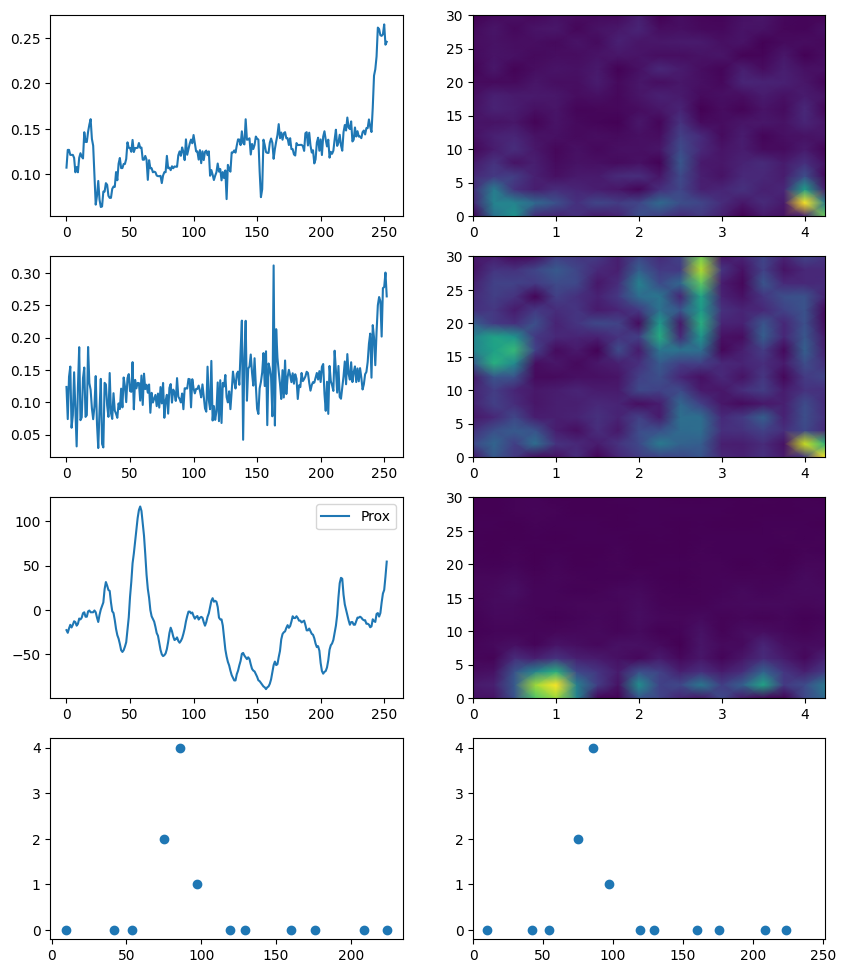

In [17]:
visualize_signals(1348,1571,30)

In [18]:
## Extract 2s window segments for a sensor
def extract_frames(sensor):
    window_size = 120
    window_step = 60
    start = 0
    end = len(sensor_ts_df) - 1
    ts_lst = []
    for win_start in range(start,end,window_step):
        win_end = win_start + window_size
        if win_end >= end:
            break
        frame = sensor_ts_df.iloc[win_start:win_end]
        if np.any(np.abs(frame['Prox'].diff()) > 100): ## discard the window if it contains diff above the threshold
            continue
        Prox_frame = frame[sensor].to_frame().T
        Prox_frame.columns = [i for i in range(120)]
        if frame.iloc[-1]['data_pt'] < frame.iloc[0]['data_pt']:
            continue
        if frame['label_eating'].mean() > 0.5:
            Prox_frame['label_eating'] = 1
            Prox_frame['label_chewing_count'] = frame['label_chewing'].sum()
        else:
            Prox_frame['label_eating'] = 0
            Prox_frame['label_chewing_count'] = 0
        Prox_frame['win_start'] = win_start
        Prox_frame['win_end'] = win_end
        ts_lst.append(Prox_frame)
    ts_df = pd.concat(ts_lst,axis = 0).reset_index(drop = True)
    return ts_df

In [19]:
## Visualize 2s window segments, compare between 1 and 0 cases in terms of psd, fft, peaks, etc.
def visualize(ts_df,prom_threshold):
    fig,ax = plt.subplots(2,3,figsize = (20,10))
    eating = ts_df.loc[ts_df['label_eating'] == 1].sample(n=3)
    non_eating = ts_df.loc[ts_df['label_eating'] == 0].sample(n=3)
    for i in range(6):
        if i < 3:
            eating_signal = eating.iloc[i][[x for x in range(120)]]
            count = eating.iloc[i]['label_chewing_count']
            #f_psd, Pxx_dens = signal.periodogram(eating_signal, fs = 60)
            #f,t,Zxx = stft(filtering(eating.iloc[i][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            peaks = find_peaks(eating_signal, height = 100,prominence= prom_threshold)
            ax[0,i].plot([x for x in range(120)],eating.iloc[i][[x for x in range(120)]])
            [ax[0,i].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(eating.iloc[i],ax[0,i+3])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[0,i+3].plot(f_psd,Pxx_dens_dB)
            ##ax[0,i+3].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[0,i+3].plot(f,Pxx_dens)
            print(count)
        else:
            non_eating_signal = non_eating.iloc[i-3][[x for x in range(120)]]
            #f_psd, Pxx_dens = signal.periodogram(non_eating.iloc[i-3][[x for x in range(120)]], fs = 60)
            ##f,t,Zxx = stft(filtering(non_eating.iloc[i-3][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            ax[1,(i-3)].plot([x for x in range(120)],non_eating.iloc[i-3][[x for x in range(120)]])
            peaks = find_peaks(non_eating_signal, height = 100,prominence=prom_threshold)
            [ax[1,(i-3)].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(non_eating.iloc[i-3],ax[1,i])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[1,i].plot(f_psd,Pxx_dens_dB)
            ##ax[1,i].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[1,i].plot(f,Pxx_dens)
    plt.show()

In [20]:
Prox_frames = extract_frames('Prox')

In [21]:
Prox_frames.iloc[113]

0                       107.711589
1                       130.705428
2                       147.699268
3                       161.693107
4                       182.686946
                          ...     
119                      98.978449
label_eating              0.000000
label_chewing_count       0.000000
win_start              7980.000000
win_end                8100.000000
Name: 113, Length: 124, dtype: float64

In [22]:
sensor_ts_df.iloc[13380:13500]

,data_pt,label,label_chewing,label_eating,File,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z
13380,336.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.072586,-0.027532,0.106115,564.550167,0.085299,0.047029,-0.055613
13381,337.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.072580,-0.037531,0.106121,467.565770,-0.044699,-0.082970,0.114380
13382,338.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.072574,-0.037529,0.096128,475.581372,-0.014696,-0.152969,0.024372
13383,339.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.072569,-0.037528,0.096134,486.596975,0.055306,-0.062968,-0.065635
13384,340.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.072563,-0.027526,0.106141,398.612578,-0.144691,0.397034,0.304358
...,...,...,...,...,...,...,...,...,...,...,...,...
13495,451.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.051918,-0.027354,0.106865,1739.344465,0.015586,-0.092827,-0.036458
13496,452.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.041912,-0.037352,0.106872,1564.360068,0.045589,-0.072826,-0.056466
13497,453.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.051906,-0.027350,0.106878,1592.375670,-0.004409,-0.102824,0.023527
13498,454.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.041900,-0.027349,0.106885,1621.391273,0.025594,-0.062823,-0.046480


In [23]:
sensor_ts_df.iloc[13500:13620]

,data_pt,label,label_chewing,label_eating,File,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z
13500,456.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.051888,-0.037346,0.096898,1718.422478,0.055599,-0.102821,-0.086495
13501,457.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.041883,-0.037344,0.116904,1729.438080,0.015601,-0.112819,0.003498
13502,458.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.051877,-0.027343,0.116911,1690.453683,0.025604,-0.072818,-0.036510
13503,459.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.051871,-0.027341,0.116917,1679.469286,0.055607,-0.092817,-0.086517
13504,460.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.041865,-0.017340,0.116924,1621.484888,0.045609,-0.092816,-0.046524
...,...,...,...,...,...,...,...,...,...,...,...,...
13615,571.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.011220,-0.017167,0.137648,1015.216776,-0.024113,-0.212676,0.032660
13616,572.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.011214,-0.017165,0.137655,-70.767622,-0.004111,-0.012675,-0.007348
13617,573.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.021208,-0.027164,0.147661,-96.752019,0.135892,-0.062674,-0.177355
13618,574.0,nan,0.0,0,./original/data_1st/7.23_breakfast/0_sensor_da...,0.011203,-0.017162,0.147668,-236.736417,-0.044106,-0.022672,0.042638


4.0
5.0
4.0


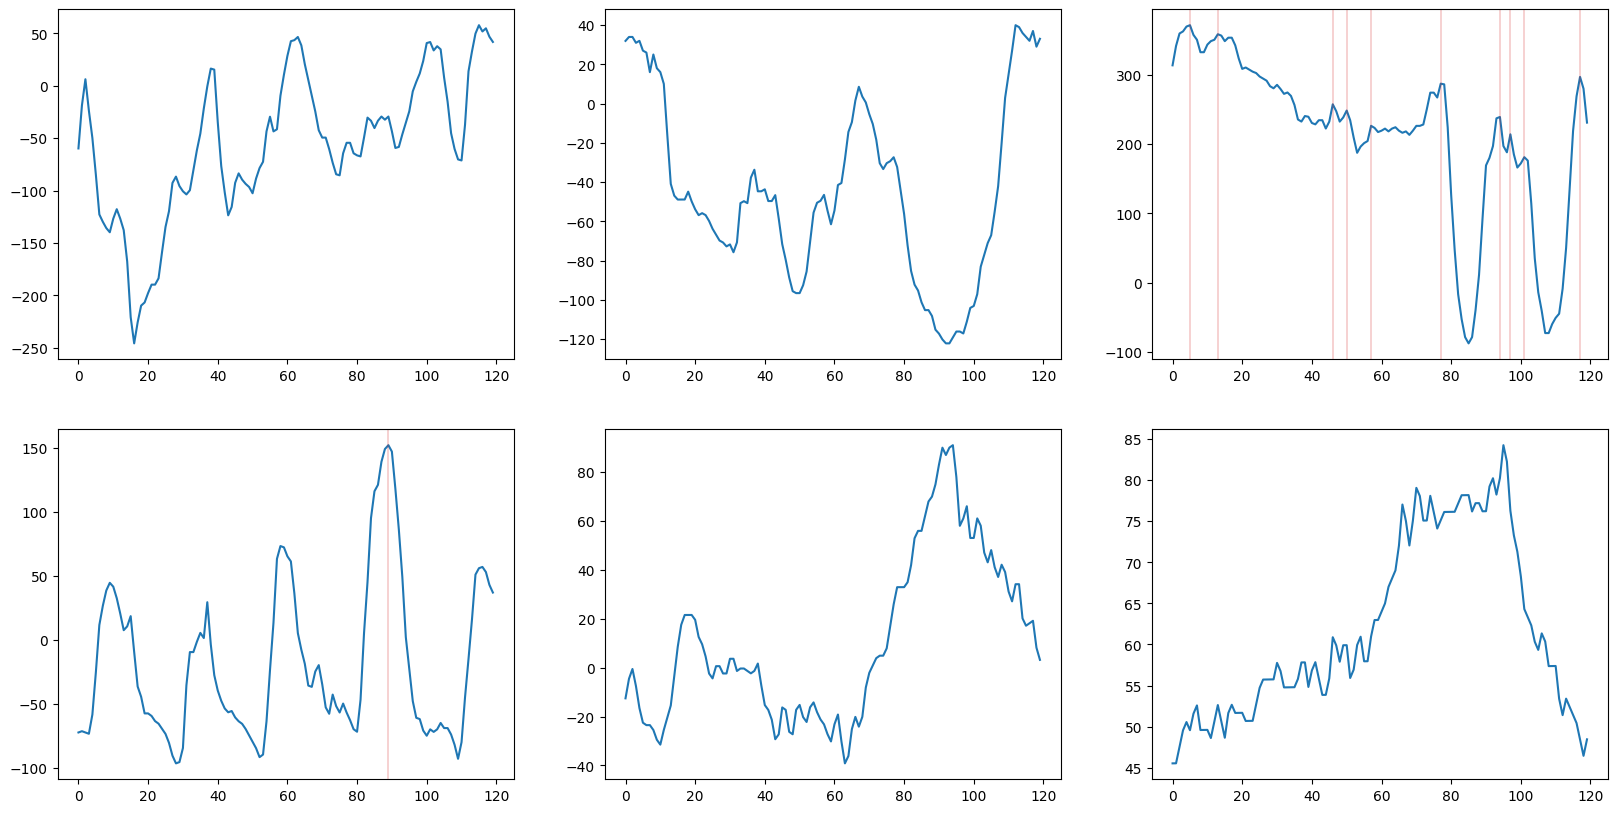

In [24]:
visualize(Prox_frames,10)